# 과제#1. 더반찬 주문량 예측

* 비지니스 상황
    * 반찬 판매량 예측을 통한 페기비용 및 기회상실 비용 절감
    * 오더 시점의 주문량이 타겟이 아니라 희망배송일의 주문량이 타겟이 됨
    * 예측 범위: 월~토(주간 예측모델): 매주 일요일 혹은 월요일 새벽에 가동된다는 가정
    * 모델 평가기간 2022-06-01 ~ 2022-06-30
    * 평가지표 R2, RMSE, 예측 정확도(abs(예측-실제)/실제)

&nbsp;
* 주의사항: Regression 사용시 미래에도 독립변수로 활용할 수 있는 인자를 사용해야함
           (예를 들어, 할인 판매 금액데이터는 미래 일주일 치를 받을 수 없음)

|	필드이름	|	유형	|	설명	|
|	----	|	----	|	----	|
|	ORD_NO 	|	STRING	|	order 시리얼 넘버	|   
|	H_YMD 	|	STRING	|	희망배송일	|  
|	O_YMD 	|	STRING	|	오더 시간	|  
|	PKG_GOODS_NO 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	PKG_GOODS_NM 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	GOODS_NO 	|	STRING	|	자재코드	|   
|	GOODS_NM 	|	STRING	|	자재명	|   
|	STD_GSGR_NO_LEV1_NM 	|	 STRING	|	자재 카테고리	|   
|	ORD_QTY 	|	 INTEGER	|	오더건수	|   
|	CANCEL_QTY 	|	 INTEGER	|	취소 오더건수	|   
|	RET_QTY 	|	 INTEGER	|	환불 오더건수	|   
|	REAL_ORD_QTY 	|	 INTEGER	|	최종 오더건수	|   
|	RECVR_ROAD_BASE_ADDR 	|	 STRING	|	주소	|   
|	SALE_PRICE 	|	 INTEGER	|	판매가격	|   
|	DISCOUNT_AMT	|	 INTEGER	|	할인액  |   
|	FINAL-PRICE 	|	 INTEGER	|	최종 판매 가격	|   

## 가설


1. 가격이 낮을수록 판매량이 많을 것이다.
2. 할인액이 높을수록 판매량이 많을 것이다.
3. 계절별로 판매되는 제품의 수가 다를 것이다.
4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
7. 카테고리별로 판매량이 다를 것이다.
8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.
14. 유통기한이 긴 제품이 여름에 더 잘팔릴 것이다.
15. 평점이 높은 제품이 취소나 환불이 적을 것이다.

In [48]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

## 0. 환경준비

### 0.1 Import

In [2]:
# 기본 라이브러리 가져오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  

### 0.2 Data Loading

In [3]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [159]:
# 카피 데이터 생성
copy_data = raw_data.copy()

#copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
copy_data = copy_data.sort_values(by = 'H_YMD')

#copy_data.to_csv('C:\\Users\\user\\Desktop\\raw.csv', index=False, encoding='utf-8-sig')

copy_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
166288,119348,201912302355791,2020-01-01 00:00:00,2019-12-30 21:59:40,단품,단품,14375,옛날잡채(500g),메인요리,1,0,0,1,"경기도 수원시 장안구 경수대로976번길 22 (조원동, 수원 한일타운)",8600,1408.0,7192
37753,37753,201912302355557,2020-01-01 00:00:00,2019-12-30 20:50:07,단품,단품,1901012353,수제계란말이(350g),반찬,2,0,0,2,서울 성북구 동소문로34길 24 삼성아파트,6300,NaN,6300
162585,115645,201912302353567,2020-01-01 00:00:00,2019-12-30 11:02:39,단품,단품,1823,숙주나물(300g),반찬,1,0,0,1,"서울특별시 마포구 삼개로 33 (도화동, 도화3지구우성아파트)",3300,486.0,2814
164041,117101,201912302354611,2020-01-01 00:00:00,2019-12-30 15:19:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,경기도 용인시 수지구 문인로3번길 22 (풍덕천동),6900,264.0,6636
164040,117100,201912302352965,2020-01-01 00:00:00,2019-12-30 10:08:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,"경기도 구리시 아차산로487번길 27 (교문동, 아차산어울림아파트)",6900,317.0,6583


## 1. 데이터 탐색

### 1.1 데이터 확인

In [85]:
# 데이터의 정보 확인
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            724702 non-null  int64         
 1   ORD_NO                724702 non-null  int64         
 2   H_YMD                 724702 non-null  datetime64[ns]
 3   O_YMD                 724702 non-null  object        
 4   PKG_GOODS_NO          724702 non-null  object        
 5   PKG_GOODS_NM          724702 non-null  object        
 6   GOODS_NO              724702 non-null  int64         
 7   GOODS_NM              724702 non-null  object        
 8   STD_GSGR_NO_LEV1_NM   724702 non-null  object        
 9   ORD_QTY               724702 non-null  int64         
 10  CANCEL_QTY            724702 non-null  int64         
 11  RET_QTY               724702 non-null  int64         
 12  REAL_ORD_QTY          724702 non-null  int64         

In [72]:
# 결측치 확인 -> DISCOUNT_AMT변수에서 376247개의 결측치 확인
# 결측치라기 보다는 할인액이 없는, 할인되지 않은 상품으로 예상되어 0으로 대체해도 될 것 같음
copy_data.isna().sum()

Unnamed: 0                   0
ORD_NO                       0
H_YMD                        0
O_YMD                        0
PKG_GOODS_NO                 0
PKG_GOODS_NM                 0
GOODS_NO                     0
GOODS_NM                     0
STD_GSGR_NO_LEV1_NM          0
ORD_QTY                      0
CANCEL_QTY                   0
RET_QTY                      0
REAL_ORD_QTY                 0
RECVR_ROAD_BASE_ADDR         0
SALE_PRICE                   0
DISCOUNT_AMT            376247
FINAL_PRICE                  0
dtype: int64

In [7]:
#PKG_GOODS_NO 정보 확인 -> 단품외에 상품이 존재
### 단품 상품이 아닌 경우 코드가 어떤 제품을 나타내는지 알아볼 필요가 있음

copy_data['PKG_GOODS_NO'].value_counts()

단품            661716
2106015591      6049
2107015727      5599
2103015234      4837
2107015647      3474
               ...  
2205016968        11
2202016453         8
2106015460         5
2202016409         3
1908013238         2
Name: PKG_GOODS_NO, Length: 77, dtype: int64

In [8]:
# PKG_GOODS_NM 정보 확인 -> 골라담기, 내일한정, 한정판매, 신규, 세트 등이 있음
### 내일한정 같은 경우는 단품으로 분류해야 하지 않을까?
copy_data['PKG_GOODS_NM'].value_counts()

단품                                        661716
더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)           9540
더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)              5599
[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)      4837
[내일한정] 두메산나물비빔밥재료                           3099
                                           ...  
매콤막창볶음밥&채소계란찜 SET                             21
신규.싱글세트18-1                                   16
신규.패밀리세트8-2                                   11
[한정판매]키즈 set                                   8
[내일한정] 꼬막무침 (250g)                             5
Name: PKG_GOODS_NM, Length: 72, dtype: int64

In [9]:
#GOODS_NM 정보 확인
copy_data['GOODS_NM'].value_counts()
#copy_data['GOODS_NM'].value_counts().sum()

두메산나물비빔밥재료                    159184
옛날잡채(500g)                    112852
셀프두부조림(600g)                   48948
숙주나물(300g)                     43906
채소계란찜(340g)                    38440
한돈 제육볶음(700g)                  35142
수제계란말이(350g)                   33080
건표고버섯볶음                        29162
꼬막무침 (250g)                    26499
양장피                            25901
가정집 오징어불고기/셀프(380g)            24389
고소한도토리묵무침(265g)                21898
건고사리나물볶음(150g)                 17556
[심방골주부X더반찬] 시골 돼지짜글이(600g)     17382
고구마 품은 라자냐(450g)               16660
우삼겹숙주볶음(250g)                  15293
순살코다리강정(180g)                  14526
메밀소바(2인분)                      13860
열무비빔밥재료믹스(2인분)                  9915
꼬막무침 (260g)                     9284
고소한도토리묵무침(360g)                 4744
고사리나물볶음(150g)                   4182
소고기유니짜장소스(1인분, 200g)            1899
Name: GOODS_NM, dtype: int64

In [10]:
#STD_GSGR_NO_LEV1_NM wjdqh 정보 확인
copy_data['STD_GSGR_NO_LEV1_NM'].value_counts()

메인요리    362212
반찬      358623
국         3867
Name: STD_GSGR_NO_LEV1_NM, dtype: int64

### 1.2 데이터 보완하기

a) PKG_GOODS_NM의 데이터를 단품 or 세트로 대체해주는 작업 실시

In [12]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {'171201310' : '두메산나물비빔밥재료', '14375':	'옛날잡채(500g)', '3273':'채소계란찜(340g)', '13957':'셀프두부조림(600g)', '1901012353':'수제계란말이(350g)',
             '13529':'메밀소바(2인분)', '1803010879':'고소한도토리묵무침(265g)', '2012014895':'한돈 제육볶음(700g)', '2204016772':'소고기유니짜장소스(1인분, 200g)', 
             '1823':'숙주나물(300g)', '4092':'건표고버섯볶음', '14985':'양장피', '1808011751':'꼬막무침 (250g)', '1903012675':'순살코다리강정(180g)', 
             '2010014667':'우삼겹숙주볶음(250g)', '1806011271':'열무비빔밥재료믹스(2인분)', '2103015231':'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             '2010014707':'고구마 품은 라자냐(450g)', '1805011121':'건고사리나물볶음(150g)', '1909013359':'가정집 오징어불고기/셀프(380g)'
             }

In [12]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_COMMENT_DIC = {'두메산나물비빔밥재료':8522, '옛날잡채(500g)':4919, '채소계란찜(340g)':5334,'셀프두부조림(600g)':3879, '수제계란말이(350g)':3683,
             '메밀소바(2인분)':1538, '고소한도토리묵무침(360g)':1159, '한돈 제육볶음(700g)':355, '소고기유니짜장소스(1인분, 200g)':931, 
             '숙주나물(300g)':4207, '건표고버섯볶음':2686, '양장피':2611, '꼬막무침 (260g)':2838, '순살코다리강정(180g)':971, 
             '우삼겹숙주볶음(250g)':593, '열무비빔밥재료믹스(2인분)':567, '[심방골주부X더반찬] 시골 돼지짜글이(600g)':612, 
             '고구마 품은 라자냐(450g)':641, '건고사리나물볶음(150g)':1210, '가정집 오징어불고기/셀프(380g)':1099
             }

In [13]:
GOODS_MEAN = sum(GOODS_COMMENT_DIC.values())/len(GOODS_COMMENT_DIC.values())

In [14]:
#copy_data['COMMNET_CNT'] = [str(GOODS_COMMENT_DIC[i]) if i in GOODS_COMMENT_DIC.keys() else str(GOODS_MEAN) for i in copy_data['GOODS_NM'] ]
copy_data['COMMNET_CNT'] = [GOODS_COMMENT_DIC[i] if i in GOODS_COMMENT_DIC.keys() else GOODS_MEAN for i in copy_data['GOODS_NM'] ]

In [15]:
copy_data['COMMNET_CNT']

166288    4919.0
37753     3683.0
162585    4207.0
164041    8522.0
164040    8522.0
           ...  
236658    1159.0
241774    1099.0
236656    1159.0
241810    1099.0
237568     567.0
Name: COMMNET_CNT, Length: 724702, dtype: float64

In [251]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '[내일한정] 수제계란말이(350g)', '메밀소바+돈까스 SET', '[내일한정] 메밀소바(2인분)', '[특판] 웰스토리 전자레인지 조리세트', '잔치상 세트', '[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)', 'SK스토아 베스트 세트', '[내일한정] 셀프두부조림(600g)', '[내일한정] 숙주나물(300g)', '[내일한정] 고소한도토리묵무침(265g)', '[내일한정] 옛날잡채(500g)', '[내일한정] 한돈 제육볶음(700g)', '[내일한정] [심방골주부X더반찬] 시골 돼지짜글이(600g)', '[내일한정] 고구마 품은 라자냐(450g)', '[내일한정] 양장피', '[내일한정] 두메산나물비빔밥재료', '[내일한정] 가정집 오징어불고기/셀프(380g)', '[내일한정] 채소계란찜(340g)', '[내일한정] 우삼겹숙주볶음(250g)', '[내일한정] 순살코다리강정(180g)', '[내일한정] 건고사리나물볶음(150g)', '[내일한정] 건표고버섯볶음', '더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)', '한돈제육세트', '더반찬& 메인메뉴 1종 + 내맘대로 2종 골라담기(15,900원부터~)', '더반찬& 고메위크 골라담기', '열무비빔밥+된찌 SET', '저녁을 부탁해 세트 A', '더반찬& 인기 밑반찬 3종 골라담기 (7,500원 부터~)', '더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)', '[내일한정] 열무비빔밥재료믹스(2인분)', '[내일한정] 꼬막무침 (250g)', '더반찬 베스트 C세트', '짭쪼름한 안주세트', '[한정판매] 두메산나물비빔밥재료', '[한정판매] 옛날잡채(500g)', '[더반찬] 주말 밥상세트 A', '[설날] 더반찬 프리미엄 차례상 (사용X)', '저녁을 부탁해 세트 B', '[내일한정] 꼬막무침 (260g)', '[내일한정] 고사리나물볶음(150g)', '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 s

In [160]:
# 내일한정, 한정판매는 단품으로 대체
# 한정판매 중에는 단품이 아닌 세트도 있어서 이를 유의해야 함(ex. '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 set')

# 내일한정이 붙은 제품은 모두 단품인 것을 확인하여 카테고리를 단품으로 바꿔줌, 
# [내일한정] 고소한도토리묵무침(265g), [내일한정] 건고사리나물볶음(150g), [내일한정] 꼬막무침 (250g)은 제외
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'

# 한정판매 중에서 두 제품만 단품이었기에 두 제품을 단품으로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'  
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 옛날잡채(500g)'] = '단품'

# 단품으로 바꿔주지 않은 모든 제품을 세트로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] != '단품'] = '세트'

C:\Users\user\AppData\Local\Temp\ipykernel_8288\1220614922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_8288\1220614922.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_8288\1220614922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [161]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '세트']


In [127]:
#자재코드와 자재명 합치기
copy_data['GOODS'] = copy_data["GOODS_NO"].astype(str) + '_' +  copy_data['GOODS_NM']
copy_data.GOODS

166288                  14375_옛날잡채(500g)
37753            1901012353_수제계란말이(350g)
162585                   1823_숙주나물(300g)
164041             1712010310_두메산나물비빔밥재료
164040             1712010310_두메산나물비빔밥재료
                       ...              
236658        1803010879_고소한도토리묵무침(360g)
241774    1909013359_가정집 오징어불고기/셀프(380g)
236656        1803010879_고소한도토리묵무침(360g)
241810    1909013359_가정집 오징어불고기/셀프(380g)
237568         1806011271_열무비빔밥재료믹스(2인분)
Name: GOODS, Length: 724702, dtype: object

d) 불필요한 컬럼 제거

In [162]:
copy_data.columns 

Index(['Unnamed: 0', 'ORD_NO', 'H_YMD', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'GOODS_NO', 'GOODS_NM', 'STD_GSGR_NO_LEV1_NM',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'RECVR_ROAD_BASE_ADDR', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE'],
      dtype='object')

In [163]:
dummy_col = ['Unnamed: 0', 'ORD_NO', 'PKG_GOODS_NO', 'RECVR_ROAD_BASE_ADDR']
copy_data = copy_data.drop(dummy_col, axis=1)

In [164]:
copy_data.tail()

,H_YMD,O_YMD,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
236658,2022-05-31 00:00:00,2022-05-25 03:16:34,단품,1803010879,고소한도토리묵무침(360g),메인요리,1,0,0,1,4500,NaN,4500
241774,2022-05-31 00:00:00,2022-05-30 15:48:24,단품,1909013359,가정집 오징어불고기/셀프(380g),메인요리,1,0,0,1,9900,1801.0,8099
236656,2022-05-31 00:00:00,2022-05-29 15:45:30,단품,1803010879,고소한도토리묵무침(360g),메인요리,1,0,0,1,4500,NaN,4500
241810,2022-05-31 00:00:00,2022-05-30 15:54:40,단품,1909013359,가정집 오징어불고기/셀프(380g),메인요리,1,0,0,1,9900,1490.0,8410
237568,2022-05-31 00:00:00,2022-05-29 22:27:28,단품,1806011271,열무비빔밥재료믹스(2인분),반찬,1,0,0,1,8900,713.0,8187


In [134]:
# 데이터 상관관계 분석
copy_data.corr()

,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
GOODS_NO,1.000000,0.009102,-0.012331,0.004310,0.015689,0.316799,0.202943,0.237327
ORD_QTY,0.009102,1.000000,0.206051,0.022218,0.826752,0.018099,0.140279,0.000686
CANCEL_QTY,-0.012331,0.206051,1.000000,-0.009708,-0.380136,-0.010178,0.032517,-0.022129
RET_QTY,0.004310,0.022218,-0.009708,1.000000,0.026582,0.003935,0.014294,-0.000072
REAL_ORD_QTY,0.015689,0.826752,-0.380136,0.026582,1.000000,0.022960,0.098884,0.013371
SALE_PRICE,0.316799,0.018099,-0.010178,0.003935,0.022960,1.000000,0.462131,0.830052
DISCOUNT_AMT,0.202943,0.140279,0.032517,0.014294,0.098884,0.462131,1.000000,-0.284285
FINAL_PRICE,0.237327,0.000686,-0.022129,-0.000072,0.013371,0.830052,-0.284285,1.000000


<AxesSubplot:>

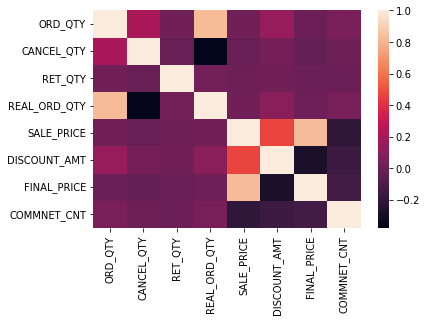

In [23]:
sns.heatmap(copy_data.corr())

### 1.3 단변량 분석

In [ ]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

In [24]:
# 그래프 한글깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'

In [25]:
#test_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv',  parse_dates=["H_YMD"])
test_data = copy_data.copy()

c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='REAL_ORD_QTY', ylabel='Density'>

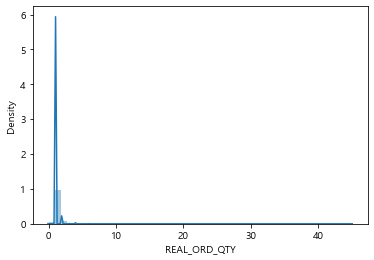

In [236]:
sns.distplot(test_data['REAL_ORD_QTY'])

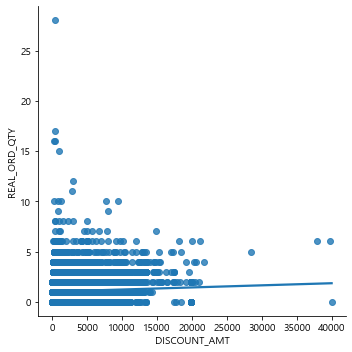

In [26]:
sns.lmplot(x='DISCOUNT_AMT', y='REAL_ORD_QTY', data=copy_data)

In [79]:
def extract_20_month(date):
    if date.year == 2020:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')

def extract_21_month(date):
    if date.year == 2021:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')

def extract_22_month(date): 
    if date.year == 2022:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')


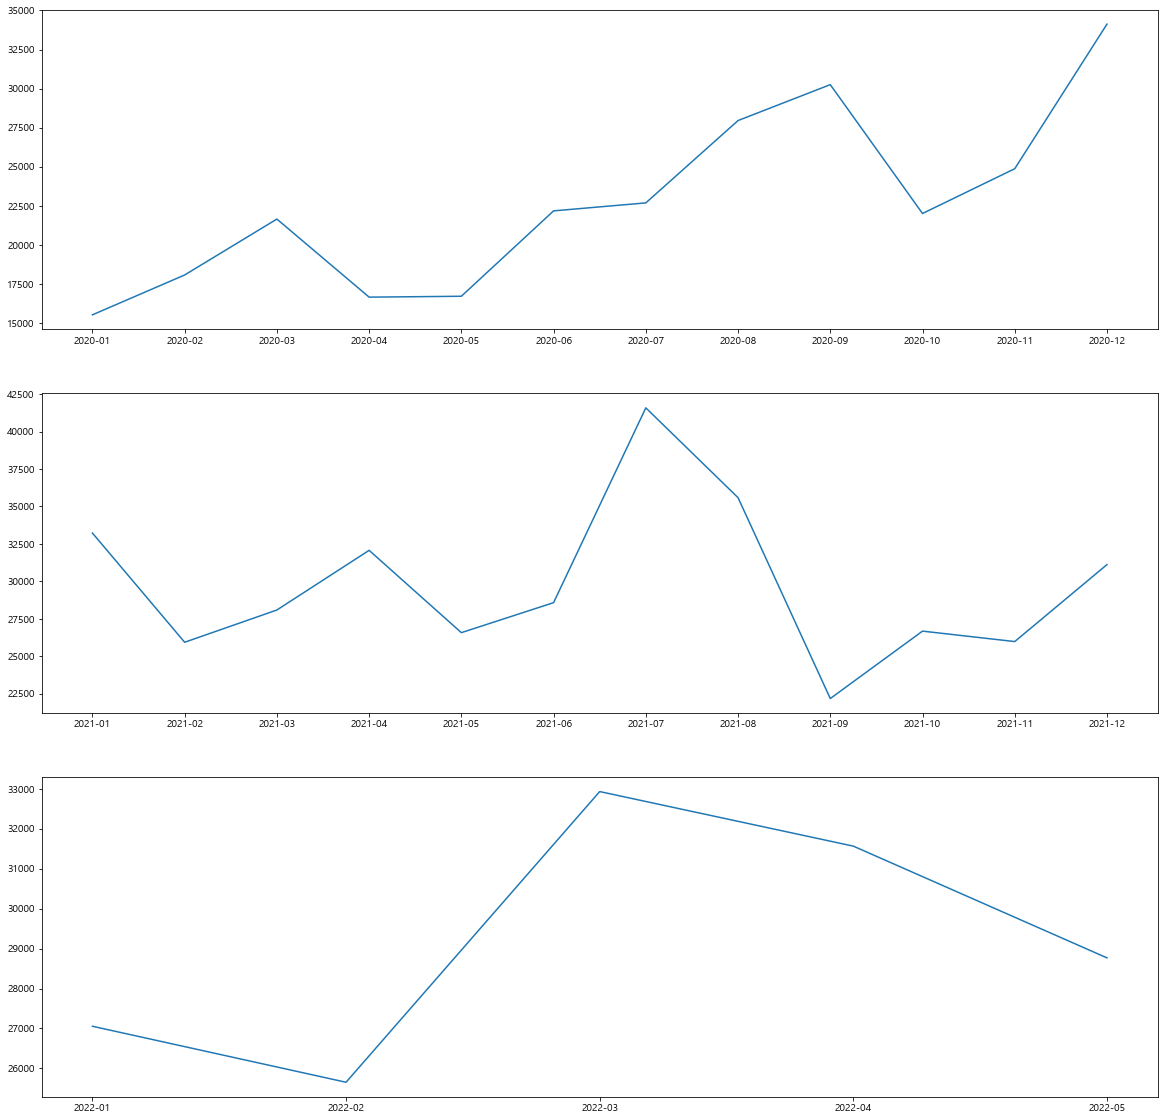

In [80]:
rev_by_20_month=test_data.set_index('H_DATETIME').groupby(extract_20_month).sum()['REAL_ORD_QTY']
rev_by_21_month=test_data.set_index('H_DATETIME').groupby(extract_21_month).sum()['REAL_ORD_QTY']
rev_by_22_month=test_data.set_index('H_DATETIME').groupby(extract_22_month).sum()['REAL_ORD_QTY']

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(rev_by_20_month)

plt.subplot(3,1,2)
plt.plot(rev_by_21_month)

plt.subplot(3,1,3)
plt.plot(rev_by_22_month)

- 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
- 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)

- 네고왕의 홍보와 새벽배송 서비스가 매우 효과적이었음을 확인할 수 있다. 
- 더반찬 어플의 경우 주 고객층의 연령대가 그리 높지 않을 것으로 추측되고, 개인부터 가족까지 그 범위가 다양하기 때문에
  그들을 공략할 수 있는 서비스와 홍보가 매우 중요하다는 것을 확인할 수 있었다.

In [81]:
test_data["O_DATETIME"] = pd.to_datetime(test_data["O_YMD"], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [82]:
def extract_20_hour(date):
    if date.year == 2020:
        return str(date.hour).rjust(2,'0')

def extract_21_hour(date):
    if date.year == 2021:
        return str(date.hour).rjust(2,'0')

def extract_22_hour(date):
    if date.year == 2022:
        return str(date.hour).rjust(2,'0')


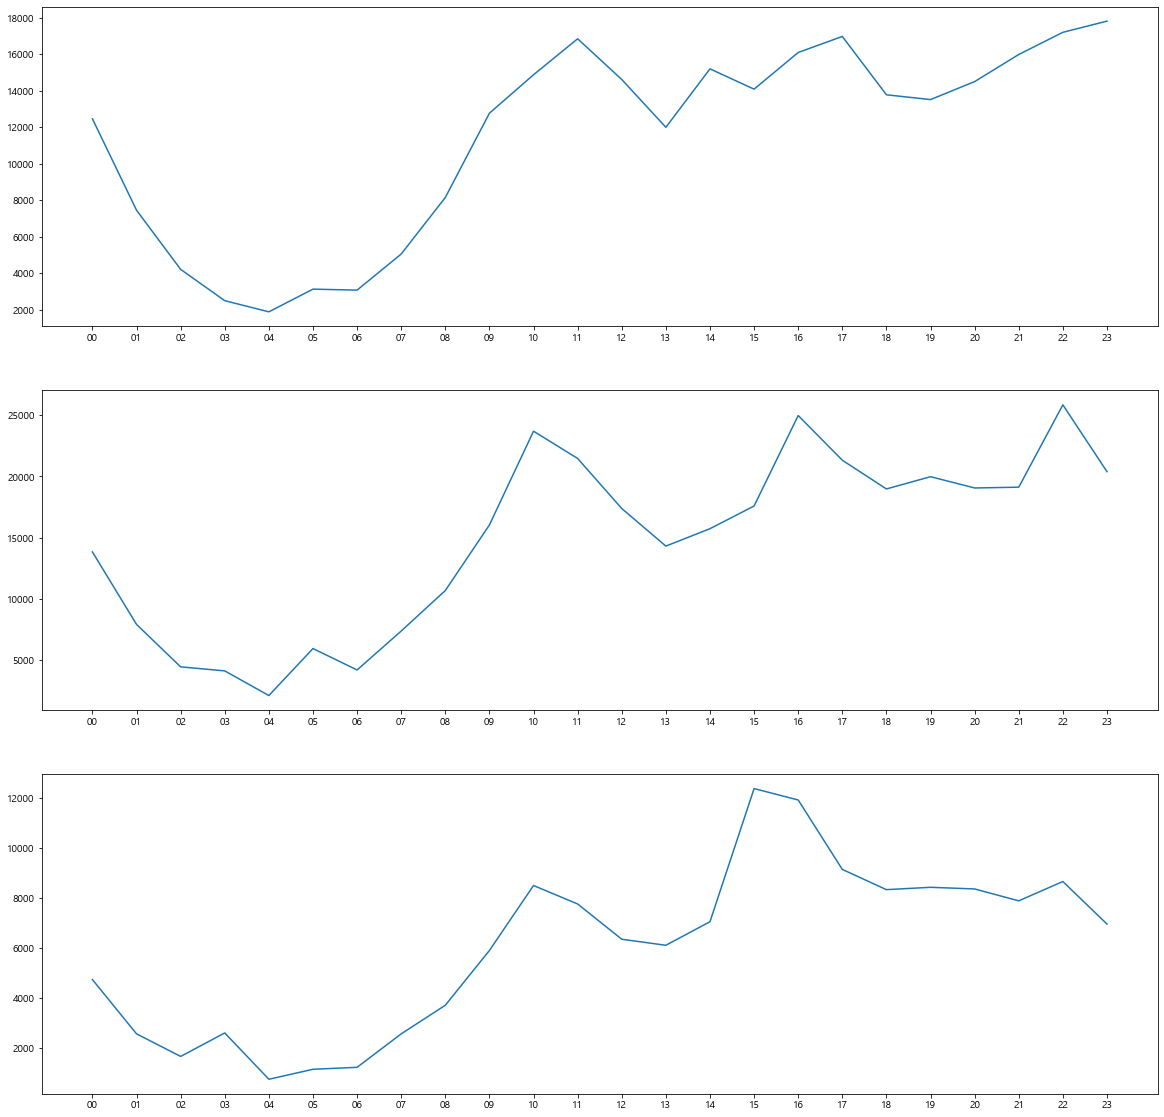

In [83]:
rev_by_20_hour=test_data.set_index('O_DATETIME').groupby(extract_20_hour).sum()['REAL_ORD_QTY']
rev_by_21_hour=test_data.set_index('O_DATETIME').groupby(extract_21_hour).sum()['REAL_ORD_QTY']
rev_by_22_hour=test_data.set_index('O_DATETIME').groupby(extract_22_hour).sum()['REAL_ORD_QTY']

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(rev_by_20_hour)

plt.subplot(3,1,2)
plt.plot(rev_by_21_hour)

plt.subplot(3,1,3)
plt.plot(rev_by_22_hour)

- 주로 점심시간 직전, 저녁시간 직전에 주문 수가 많아지는 것을 확인할 수 있다.
- 배가고플 때 일반적으로 배달앱을 많이 키는 것처럼 더반찬 사이트에도 많이 접속하는 것으로 볼 수 있다.
- 사람들이 배가 고플 때 배달 어플이 아니라 더반찬 어플을 사용할 수 있는 이유을 만들어 주면 더 높은 매출을 달성할 수 있을것이다.

In [85]:
copy_data.groupby(["GOODS", "PKG_GOODS_NM"])['REAL_ORD_QTY'].sum().to_frame()

REAL_ORD_QTY
GOODS                                 PKG_GOODS_NM              
13529_메밀소바(2인분)                       단품                   14747
                                      세트                    1278
13957_셀프두부조림(600g)                    단품                   51600
14375_옛날잡채(500g)                      단품                  116989
                                      세트                    6414
14985_양장피                             단품                   26697
                                      세트                      36
1712010310_두메산나물비빔밥재료                 단품                  169708
                                      세트                    8433
1803010879_고소한도토리묵무침(265g)            단품                   22399
1803010879_고소한도토리묵무침(360g)            단품                    4817
1805011121_건고사리나물볶음(150g)             단품                   17964
1805011121_고사리나물볶음(150g)              단품                    4233
1806011271_열무비빔밥재료믹스(2인분)             단품                    7594
                                      세트                    2792
1808011751_꼬막무침 (250g)                단품                   27054
                                      세트                      39
1808011751_꼬막무침 (260g)                단품                    9708
1823_숙주나물(300g)                       단품                   42904
                                      세트                     943
1901012353_수제계란말이(350g)               단품                   34469
                                      세트                      29
1903012675_순살코다리강정(180g)              단품                   16731
                                      세트                     104
1909013359_가정집 오징어불고기/셀프(380g)        단품                   25207
                                      세트                     679
2010014667_우삼겹숙주볶음(250g)              단품                   16990
                                      세트                      29
2010014707_고구마 품은 라자냐(450g)           단품                   18135
                                      세트                     259
2012014895_한돈 제육볶음(700g)              단품                   32039
                                      세트                    4571
2103015231_[심방골주부X더반찬] 시골 돼지짜글이(600g) 단품                   13208
                                      세트                    4900
2204016772_소고기유니짜장소스(1인분, 200g)       단품                    1158
                                      세트                     966
3273_채소계란찜(340g)                      단품                   40616
                                      세트                      60
4092_건표고버섯볶음                          단품                   29752

- 반찬일 경우 세트로 주문할 확률이 높을 것이다.

In [284]:
copy_data['STD_GSGR_NO_LEV1_NM'].value_counts()

메인요리    362212
반찬      358623
국         3867
Name: STD_GSGR_NO_LEV1_NM, dtype: int64

In [86]:
copy_data['PKG_GOODS_NM'].value_counts()

단품    692612
세트     32090
Name: PKG_GOODS_NM, dtype: int64

In [87]:
copy_data.groupby(["STD_GSGR_NO_LEV1_NM", "PKG_GOODS_NM"])['REAL_ORD_QTY'].count().to_frame()

REAL_ORD_QTY
STD_GSGR_NO_LEV1_NM PKG_GOODS_NM              
국                   단품                    2676
                    세트                    1191
메인요리                단품                  337126
                    세트                   25086
반찬                  단품                  352810
                    세트                    5813

<AxesSubplot:xlabel='STD_GSGR_NO_LEV1_NM', ylabel='count'>

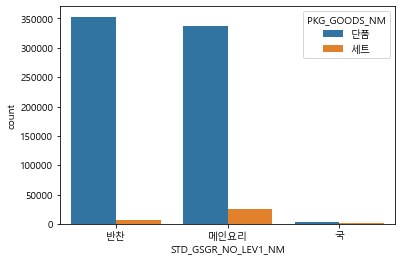

In [89]:
sns.countplot(data=copy_data, x="STD_GSGR_NO_LEV1_NM", hue='PKG_GOODS_NM')

- 큰 차이는 아니지만 예상 외로 메인보다 반찬의 경우가 세트로 팔릴 확률이 높은 것으로 나타났다.
- 국의 경우는 단품과 세트로 사는 경우가 반반이었다.

In [113]:
copy_data['GOODS'].loc[(copy_data['STD_GSGR_NO_LEV1_NM']=='반찬') & (copy_data['PKG_GOODS_NM']=='세트')].value_counts().to_frame()

,GOODS
1806011271_열무비빔밥재료믹스(2인분),2835
1823_숙주나물(300g),971
"2204016772_소고기유니짜장소스(1인분, 200g)",970
1712010310_두메산나물비빔밥재료,395
1909013359_가정집 오징어불고기/셀프(380g),376
1903012675_순살코다리강정(180g),105
3273_채소계란찜(340g),58
1808011751_꼬막무침 (250g),39
1901012353_수제계란말이(350g),32
2010014667_우삼겹숙주볶음(250g),32


- 세트로 팔린 반찬의 경우 주로 메인에 필요한 재료들이 세트로 팔린 것을 확인할 수 있다.
- 정말 반찬으로 소비되는 식품을 세트로 사는 경우는 매우 희박한 것을 확인할 수 있었다.

In [29]:
test_data['DATE_DIFF'] = pd.to_datetime(copy_data['O_YMD']) - pd.to_datetime(copy_data['H_YMD'])

In [33]:
test_data['DATE_DIFF'] = pd.to_numeric(test_data['DATE_DIFF'])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724702 entries, 0 to 724701
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   O_YMD                724702 non-null  object 
 2   PKG_GOODS_NM         724702 non-null  object 
 3   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 4   ORD_QTY              724702 non-null  int64  
 5   CANCEL_QTY           724702 non-null  int64  
 6   RET_QTY              724702 non-null  int64  
 7   REAL_ORD_QTY         724702 non-null  int64  
 8   SALE_PRICE           724702 non-null  int64  
 9   DISCOUNT_AMT         348455 non-null  float64
 10  FINAL_PRICE          724702 non-null  int64  
 11  GOODS                724702 non-null  object 
 12  DATE_DIFF            724702 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 71.9+ MB


In [35]:
test_data['DATE_DIFF']

0        -128030000000000
1         -48251000000000
2         -44488000000000
3        -124689000000000
4         -56619000000000
               ...       
724697   -601768000000000
724698   -217316000000000
724699   -186933000000000
724700   -189585000000000
724701   -204960000000000
Name: DATE_DIFF, Length: 724702, dtype: int64

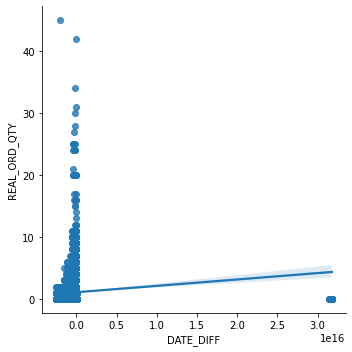

In [34]:
sns.lmplot(x='DATE_DIFF', y='REAL_ORD_QTY', data=test_data)

### 1.4 이변량 분석

## 2. 데이터 전처리

### 2.1 이상치 처리

In [395]:
copy_data.describe()

,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
count,724702.00000,724702.000000,724702.000000,724702.000000,724702.000000,348455.000000,724702.000000
mean,1.12172,0.050588,0.003917,1.071131,7262.438891,1118.631562,6724.572622
std,0.47063,0.286248,0.071317,0.497911,2417.240294,1852.828670,2388.223550
min,1.00000,0.000000,0.000000,0.000000,2600.000000,0.000000,-31390.000000
25%,1.00000,0.000000,0.000000,1.000000,4900.000000,169.000000,4783.000000
50%,1.00000,0.000000,0.000000,1.000000,7000.000000,480.000000,6900.000000
75%,1.00000,0.000000,0.000000,1.000000,8800.000000,1250.000000,8600.000000
max,45.00000,31.000000,7.000000,45.000000,35600.000000,39990.000000,35600.000000


c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-package

<AxesSubplot:xlabel='FINAL_PRICE'>

c:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


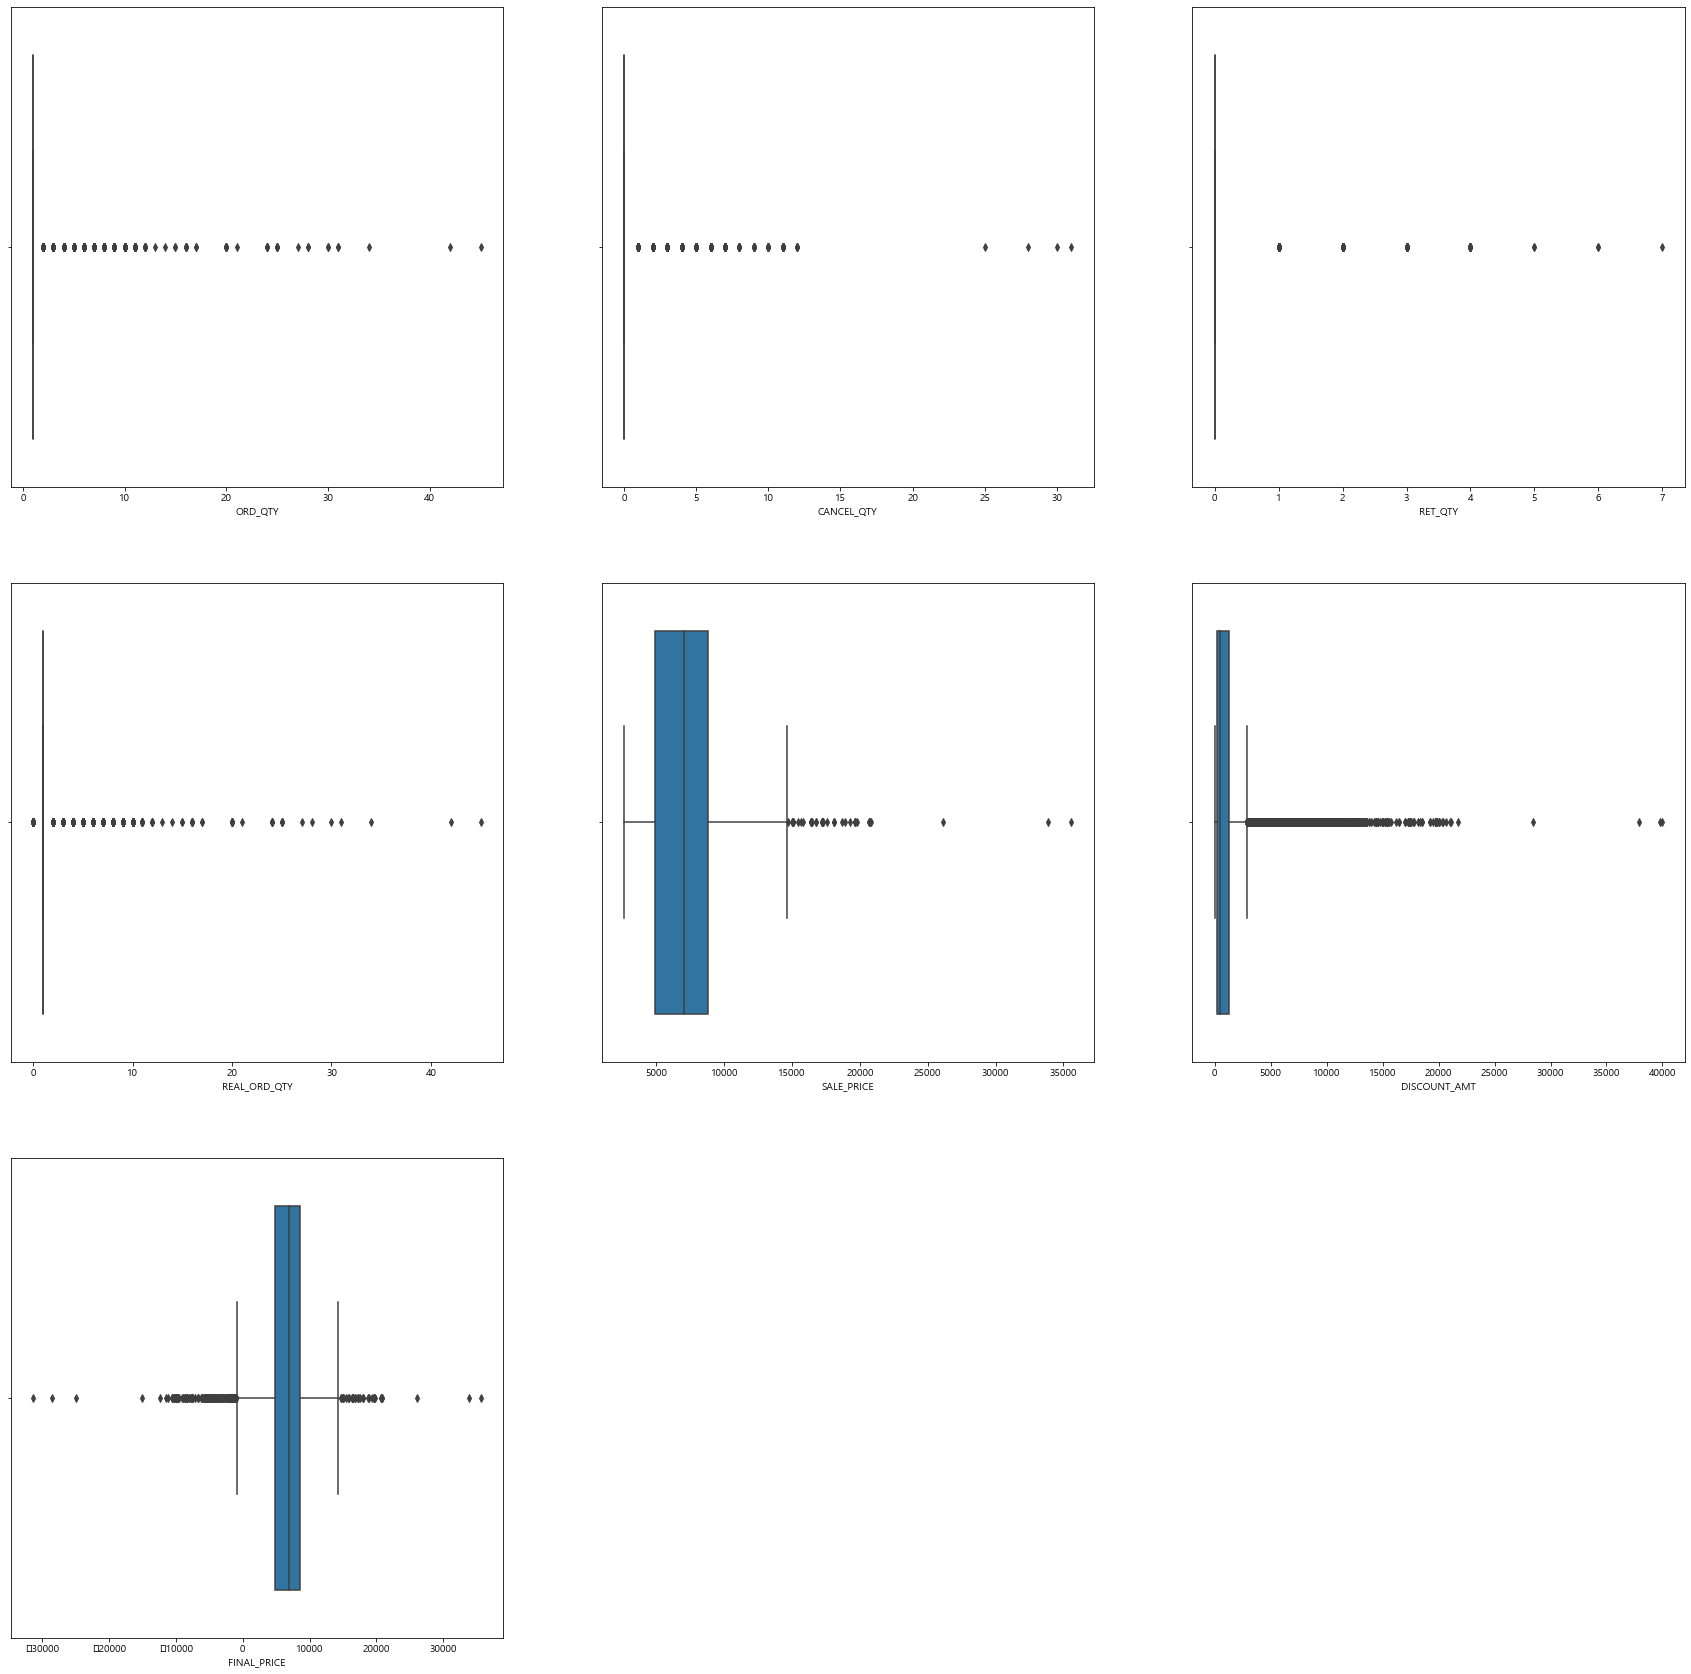

In [396]:
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
sns.boxplot(x='ORD_QTY',  orient = "v", data=copy_data)

plt.subplot(3,3,2)
sns.boxplot(x='CANCEL_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,3)
sns.boxplot(x='RET_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,4)
sns.boxplot(x='REAL_ORD_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,5)
sns.boxplot(x='SALE_PRICE', orient = "v", data=copy_data)

plt.subplot(3,3,6)
sns.boxplot(x='DISCOUNT_AMT', orient = "v", data=copy_data)

plt.subplot(3,3,7)
sns.boxplot(x='FINAL_PRICE', orient = "v", data=copy_data)


In [149]:
q1 = copy_data['ORD_QTY'].quantile(0.25)
q1
q3 = copy_data['ORD_QTY'].quantile(0.75)
q3

1.0

In [165]:
def outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    df.loc[(df[col] > (q3 + 1.5 * iqr)) | (df[col] < (q1 - 1.5 * iqr)), col] = df[col].median()

In [166]:
ol_col = ['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY', 'SALE_PRICE', 'FINAL_PRICE']

for i in ol_col:
    print(i)
    outlier(copy_data, i)


ORD_QTY
CANCEL_QTY
RET_QTY
REAL_ORD_QTY
SALE_PRICE
FINAL_PRICE


In [34]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   PKG_GOODS_NM         724702 non-null  object 
 2   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 3   ORD_QTY              724702 non-null  int64  
 4   CANCEL_QTY           724702 non-null  int64  
 5   RET_QTY              724702 non-null  int64  
 6   REAL_ORD_QTY         724702 non-null  int64  
 7   SALE_PRICE           724702 non-null  int64  
 8   DISCOUNT_AMT         348455 non-null  float64
 9   FINAL_PRICE          724702 non-null  int64  
 10  COMMNET_CNT          724702 non-null  float64
 11  GOODS                724702 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 71.9+ MB


c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-package

<AxesSubplot:xlabel='FINAL_PRICE'>

c:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


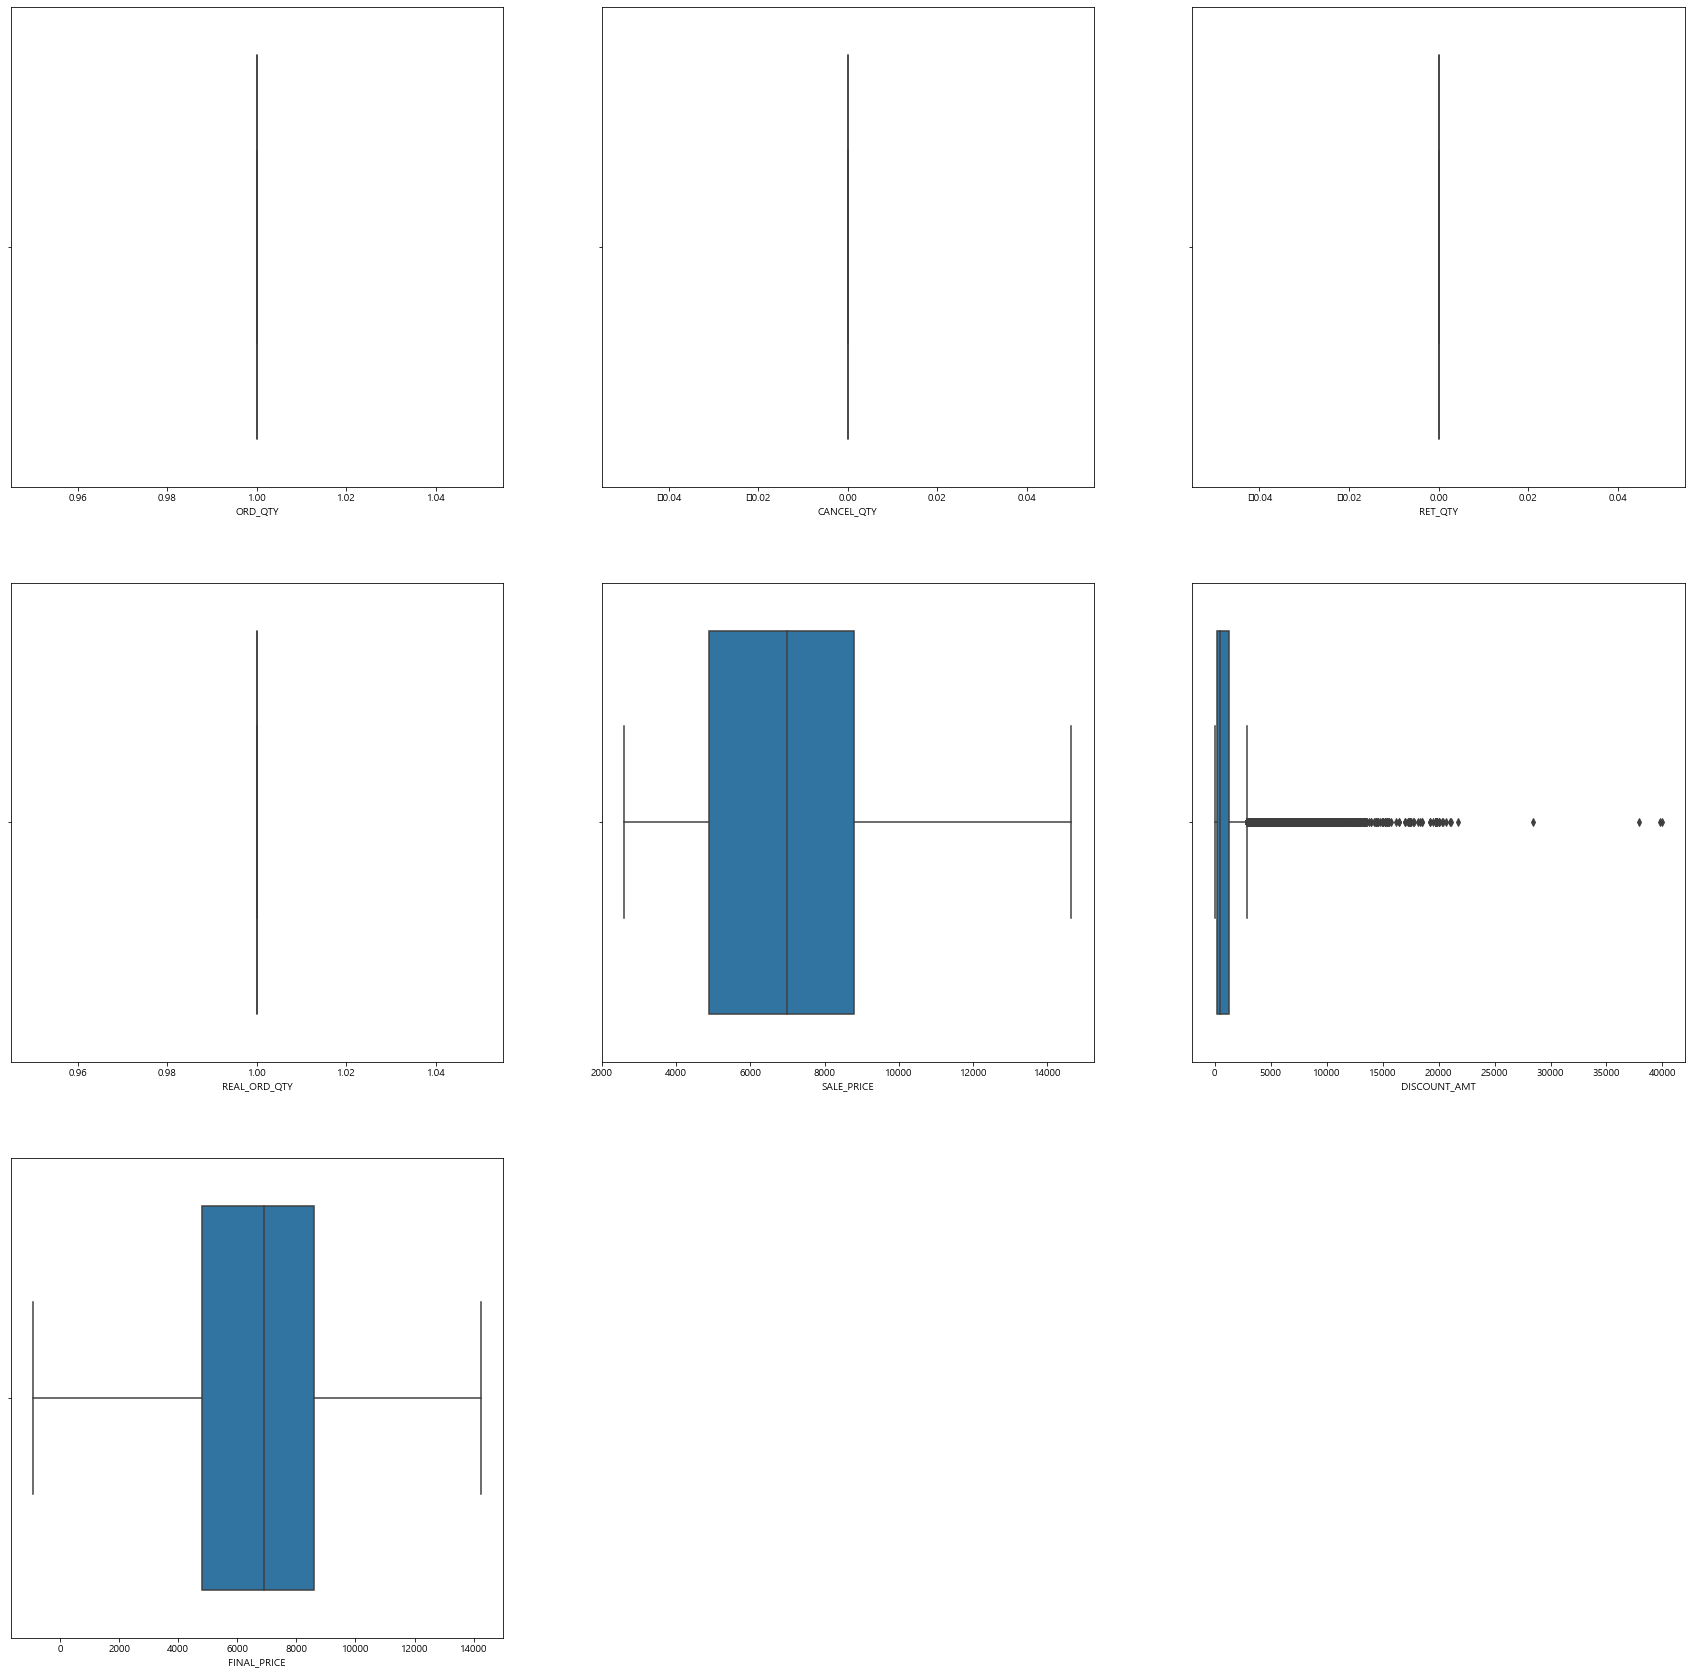

In [35]:
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
sns.boxplot(x='ORD_QTY',  orient = "v", data=copy_data)

plt.subplot(3,3,2)
sns.boxplot(x='CANCEL_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,3)
sns.boxplot(x='RET_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,4)
sns.boxplot(x='REAL_ORD_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,5)
sns.boxplot(x='SALE_PRICE', orient = "v", data=copy_data)

plt.subplot(3,3,6)
sns.boxplot(x='DISCOUNT_AMT', orient = "v", data=copy_data)

plt.subplot(3,3,7)
sns.boxplot(x='FINAL_PRICE', orient = "v", data=copy_data)


c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='REAL_ORD_QTY', ylabel='Density'>

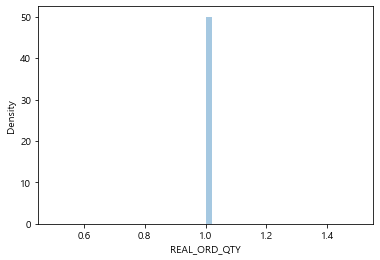

In [36]:
sns.distplot(copy_data['REAL_ORD_QTY'])

In [37]:
copy_data.isna().sum()

H_YMD                       0
PKG_GOODS_NM                0
STD_GSGR_NO_LEV1_NM         0
ORD_QTY                     0
CANCEL_QTY                  0
RET_QTY                     0
REAL_ORD_QTY                0
SALE_PRICE                  0
DISCOUNT_AMT           376247
FINAL_PRICE                 0
COMMNET_CNT                 0
GOODS                       0
dtype: int64

In [167]:
copy_data['DISCOUNT_AMT'].fillna(0, inplace=True)

In [83]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   PKG_GOODS_NM         724702 non-null  object 
 2   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 3   ORD_QTY              724702 non-null  int64  
 4   CANCEL_QTY           724702 non-null  int64  
 5   RET_QTY              724702 non-null  int64  
 6   REAL_ORD_QTY         724702 non-null  int64  
 7   SALE_PRICE           724702 non-null  int64  
 8   DISCOUNT_AMT         724702 non-null  float64
 9   FINAL_PRICE          724702 non-null  int64  
 10  GOODS                724702 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 66.3+ MB


In [40]:
copy_data.dropna(inplace=True)

In [168]:
copy_data.isna().sum()

H_YMD                  0
O_YMD                  0
PKG_GOODS_NM           0
GOODS_NO               0
GOODS_NM               0
STD_GSGR_NO_LEV1_NM    0
ORD_QTY                0
CANCEL_QTY             0
RET_QTY                0
REAL_ORD_QTY           0
SALE_PRICE             0
DISCOUNT_AMT           0
FINAL_PRICE            0
dtype: int64

### 2.3 가변수화

In [169]:
cols = ['PKG_GOODS_NM', 'STD_GSGR_NO_LEV1_NM', 'GOODS_NM']

#copy_data= pd.get_dummies(copy_data, columns = cols ,drop_first = True)
copy_data= pd.get_dummies(copy_data, columns = cols)

### 2.4 주 별 데이터로 묶기

In [170]:
copy_data

,H_YMD,O_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
166288,2020-01-01 00:00:00,2019-12-30 21:59:40,14375,1,0,0,1,8600,1408.0,7192,...,0,0,0,0,0,0,1,0,0,0
37753,2020-01-01 00:00:00,2019-12-30 20:50:07,1901012353,1,0,0,1,6300,0.0,6300,...,0,1,0,0,0,0,0,0,0,0
162585,2020-01-01 00:00:00,2019-12-30 11:02:39,1823,1,0,0,1,3300,486.0,2814,...,0,0,1,0,0,0,0,0,0,0
164041,2020-01-01 00:00:00,2019-12-30 15:19:58,1712010310,1,0,0,1,6900,264.0,6636,...,0,0,0,0,0,0,0,0,0,0
164040,2020-01-01 00:00:00,2019-12-30 10:08:58,1712010310,1,0,0,1,6900,317.0,6583,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,2022-05-25 03:16:34,1803010879,1,0,0,1,4500,0.0,4500,...,0,0,0,0,0,0,0,0,0,0
241774,2022-05-31 00:00:00,2022-05-30 15:48:24,1909013359,1,0,0,1,9900,1801.0,8099,...,0,0,0,0,0,0,0,0,0,0
236656,2022-05-31 00:00:00,2022-05-29 15:45:30,1803010879,1,0,0,1,4500,0.0,4500,...,0,0,0,0,0,0,0,0,0,0
241810,2022-05-31 00:00:00,2022-05-30 15:54:40,1909013359,1,0,0,1,9900,1490.0,8410,...,0,0,0,0,0,0,0,0,0,0


In [171]:
copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])

In [172]:
copy_data['O_YMD'] = pd.to_numeric(pd.to_datetime(copy_data['O_YMD']))

In [173]:
resampled = copy_data.resample(rule='1W', on='H_YMD')
resampled.sum()

copy_data = resampled.sum()

In [174]:
copy_data

,O_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_단품,...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
H_YMD,,,,,,,,,,,,,,,,,,,,,
2020-01-05,3.482301e+21,1.961055e+12,2207.0,0.0,0.0,2207.0,15276300.0,445544.0,14830756.0,2203.0,...,0.0,91.0,132.0,62.0,87.0,0.0,502.0,0.0,127.0,0.0
2020-01-12,6.013455e+21,3.321217e+12,3810.0,0.0,0.0,3810.0,25869300.0,818906.0,25050394.0,3804.0,...,0.0,186.0,237.0,94.0,146.0,0.0,796.0,0.0,251.0,0.0
2020-01-19,4.935759e+21,2.606289e+12,3126.0,0.0,0.0,3126.0,21531500.0,1353214.0,20178286.0,3122.0,...,0.0,1.0,263.0,81.0,122.0,0.0,753.0,0.0,10.0,0.0
2020-01-26,5.813741e+21,2.402659e+12,3681.0,0.0,0.0,3681.0,27642900.0,906740.0,26736160.0,3590.0,...,0.0,0.0,221.0,67.0,193.0,0.0,1586.0,0.0,6.0,0.0
2020-02-02,3.640794e+21,2.007864e+12,2304.0,0.0,0.0,2304.0,15042100.0,353598.0,14688502.0,2293.0,...,0.0,59.0,223.0,93.0,123.0,0.0,310.0,0.0,90.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,1.002654e+22,6.589453e+12,6071.0,0.0,0.0,6071.0,43461860.0,3956951.0,39514209.0,5811.0,...,307.0,226.0,364.0,182.0,339.0,0.0,768.0,122.0,394.0,357.0
2022-05-15,1.060021e+22,7.486064e+12,6416.0,0.0,0.0,6416.0,44551710.0,3899804.0,40678586.0,6108.0,...,294.0,308.0,401.0,377.0,236.0,0.0,688.0,133.0,412.0,294.0
2022-05-22,1.014457e+22,6.895001e+12,6138.0,0.0,0.0,6138.0,43893380.0,3416661.0,40495742.0,5917.0,...,274.0,299.0,338.0,331.0,292.0,136.0,687.0,148.0,449.0,278.0


In [100]:
copy_data.to_csv('C:\\Users\\user\\Desktop\\raw.csv', index=False, encoding='utf-8-sig')

### 2.2 target, feature 분리

In [175]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

copy_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in copy_data.columns.values]

In [176]:
train_data = copy_data[:121]
test_data = copy_data[121:]

test_data.head()

,O_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_단품,...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-01,1.083518e+22,7.263651e+12,6563.0,0.0,0.0,6563.0,46621200.0,4610151.0,42039605.0,6247.0,...,389.0,323.0,387.0,209.0,310.0,0.0,743.0,124.0,470.0,328.0
2022-05-08,1.002654e+22,6.589453e+12,6071.0,0.0,0.0,6071.0,43461860.0,3956951.0,39514209.0,5811.0,...,307.0,226.0,364.0,182.0,339.0,0.0,768.0,122.0,394.0,357.0
2022-05-15,1.060021e+22,7.486064e+12,6416.0,0.0,0.0,6416.0,44551710.0,3899804.0,40678586.0,6108.0,...,294.0,308.0,401.0,377.0,236.0,0.0,688.0,133.0,412.0,294.0
2022-05-22,1.014457e+22,6.895001e+12,6138.0,0.0,0.0,6138.0,43893380.0,3416661.0,40495742.0,5917.0,...,274.0,299.0,338.0,331.0,292.0,136.0,687.0,148.0,449.0,278.0
2022-05-29,1.009022e+22,6.299480e+12,6103.0,0.0,0.0,6103.0,43655170.0,3195566.0,40459604.0,5848.0,...,265.0,267.0,617.0,183.0,240.0,316.0,537.0,137.0,379.0,336.0


In [177]:
train_data.columns

Index(['O_YMD', 'GOODS_NO', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'PKG_GOODS_NM_단품',
       'PKG_GOODS_NM_세트', 'STD_GSGR_NO_LEV1_NM_국', 'STD_GSGR_NO_LEV1_NM_메인요리',
       'STD_GSGR_NO_LEV1_NM_반찬', 'GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_NM_가정집 오징어불고기/셀프(380g)', 'GOODS_NM_건고사리나물볶음(150g)',
       'GOODS_NM_건표고버섯볶음', 'GOODS_NM_고구마 품은 라자냐(450g)',
       'GOODS_NM_고사리나물볶음(150g)', 'GOODS_NM_고소한도토리묵무침(265g)',
       'GOODS_NM_고소한도토리묵무침(360g)', 'GOODS_NM_꼬막무침 (250g)',
       'GOODS_NM_꼬막무침 (260g)', 'GOODS_NM_두메산나물비빔밥재료', 'GOODS_NM_메밀소바(2인분)',
       'GOODS_NM_셀프두부조림(600g)', 'GOODS_NM_소고기유니짜장소스(1인분, 200g)',
       'GOODS_NM_수제계란말이(350g)', 'GOODS_NM_숙주나물(300g)',
       'GOODS_NM_순살코다리강정(180g)', 'GOODS_NM_양장피', 'GOODS_NM_열무비빔밥재료믹스(2인분)',
       'GOODS_NM_옛날잡채(500g)', 'GOODS_NM_우삼겹숙주볶음(250g)', 'GOODS_NM_채소계란찜(340g)',
       'GOODS_NM_한돈 제육볶음(700g)'],
      dtype='object')

In [178]:
target = ['GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_NM_가정집 오징어불고기/셀프(380g)', 'GOODS_NM_건고사리나물볶음(150g)',
       'GOODS_NM_건표고버섯볶음', 'GOODS_NM_고구마 품은 라자냐(450g)',
       'GOODS_NM_고사리나물볶음(150g)', 'GOODS_NM_고소한도토리묵무침(265g)',
       'GOODS_NM_고소한도토리묵무침(360g)', 'GOODS_NM_꼬막무침 (250g)',
       'GOODS_NM_꼬막무침 (260g)', 'GOODS_NM_두메산나물비빔밥재료', 'GOODS_NM_메밀소바(2인분)',
       'GOODS_NM_셀프두부조림(600g)', 'GOODS_NM_소고기유니짜장소스(1인분, 200g)',
       'GOODS_NM_수제계란말이(350g)', 'GOODS_NM_숙주나물(300g)',
       'GOODS_NM_순살코다리강정(180g)', 'GOODS_NM_양장피', 'GOODS_NM_열무비빔밥재료믹스(2인분)',
       'GOODS_NM_옛날잡채(500g)', 'GOODS_NM_우삼겹숙주볶음(250g)', 'GOODS_NM_채소계란찜(340g)',
       'GOODS_NM_한돈 제육볶음(700g)']
X, X_test = copy_data[:121].drop(target, axis=1), copy_data[121:].drop(target, axis=1)
y, y_test = copy_data[:121][target], copy_data[121:][target]

In [179]:
y_test

,GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g),GOODS_NM_가정집 오징어불고기/셀프(380g),GOODS_NM_건고사리나물볶음(150g),GOODS_NM_건표고버섯볶음,GOODS_NM_고구마 품은 라자냐(450g),GOODS_NM_고사리나물볶음(150g),GOODS_NM_고소한도토리묵무침(265g),GOODS_NM_고소한도토리묵무침(360g),GOODS_NM_꼬막무침 (250g),GOODS_NM_꼬막무침 (260g),...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-01,163.0,191.0,0.0,308.0,142.0,114.0,0.0,299.0,0.0,355.0,...,389.0,323.0,387.0,209.0,310.0,0.0,743.0,124.0,470.0,328.0
2022-05-08,183.0,176.0,0.0,253.0,130.0,148.0,0.0,373.0,0.0,234.0,...,307.0,226.0,364.0,182.0,339.0,0.0,768.0,122.0,394.0,357.0
2022-05-15,215.0,183.0,0.0,233.0,233.0,181.0,0.0,449.0,0.0,250.0,...,294.0,308.0,401.0,377.0,236.0,0.0,688.0,133.0,412.0,294.0
2022-05-22,174.0,172.0,0.0,159.0,155.0,183.0,0.0,320.0,0.0,202.0,...,274.0,299.0,338.0,331.0,292.0,136.0,687.0,148.0,449.0,278.0
2022-05-29,145.0,109.0,0.0,216.0,141.0,193.0,0.0,280.0,0.0,176.0,...,265.0,267.0,617.0,183.0,240.0,316.0,537.0,137.0,379.0,336.0
2022-06-05,51.0,48.0,0.0,70.0,46.0,50.0,0.0,97.0,0.0,42.0,...,93.0,102.0,127.0,40.0,54.0,81.0,177.0,57.0,136.0,83.0


### 2.4 추가 옵션 도출(feature Engineering)

### 2.5 데이터 분할

In [180]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, random_state = 2022)

In [181]:
X_train.shape

(84, 14)

In [182]:
X_train.head()

,O_YMD,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_단품,PKG_GOODS_NM_세트,STD_GSGR_NO_LEV1_NM_국,STD_GSGR_NO_LEV1_NM_메인요리,STD_GSGR_NO_LEV1_NM_반찬
H_YMD,,,,,,,,,,,,,,
2020-01-12,6.013455e+21,3.321217e+12,3810.0,0.0,0.0,3810.0,25869300.0,818906.0,25050394.0,3804.0,6.0,0.0,1960.0,1850.0
2020-06-28,8.883152e+21,5.454780e+12,5577.0,0.0,0.0,5577.0,39839890.0,2470593.0,37410591.0,5341.0,236.0,0.0,3029.0,2548.0
2021-01-17,1.295383e+22,8.851946e+12,8044.0,0.0,0.0,8044.0,57926640.0,3303336.0,54638304.0,8019.0,25.0,0.0,4256.0,3788.0
2020-02-23,5.872262e+21,2.978308e+12,3712.0,0.0,0.0,3712.0,24895200.0,807658.0,24087542.0,3711.0,1.0,0.0,1820.0,1892.0
2020-07-05,7.229420e+21,4.093185e+12,4537.0,0.0,0.0,4537.0,31468470.0,1313647.0,30164533.0,4336.0,201.0,0.0,2377.0,2160.0


### 2.6 스케일링

In [183]:
from sklearn.preprocessing import MinMaxScaler
col_x = list(X)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

## 3. 모델링

- XGBoost 모델

In [181]:
!pip install xgboost

In [99]:
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

In [186]:
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.08, 
    gamma=0, 
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7)

In [187]:
xgb_model.fit(
    X_train_s, 
    y_train, 
    eval_metric="rmse"
    )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [188]:
Y_pred = xgb_model.predict(X_val)

In [189]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, Y_pred)
r2

-2.598880472987073

In [190]:
Y_pred

array([[ 2.8567642e+02,  1.7352576e+02,  2.0628876e+02,  4.3964984e+02,
         2.7438773e+02, -1.8850541e-01,  2.5728775e+02,  6.2256695e+01,
         1.3109145e+02,  4.9665141e+00,  2.3710237e+03,  7.4518060e+02,
         5.7807135e+02, -3.7258381e-01,  3.3145770e+02,  7.3902802e+02,
         1.8843036e+02,  2.8603186e+02,  5.2439160e+02,  7.9952484e+02,
         2.6509866e+02,  5.5645673e+02,  9.3645105e+02],
       [ 2.8567642e+02,  1.7352576e+02,  2.0628876e+02,  4.3964984e+02,
         2.7438773e+02, -1.8850541e-01,  2.5728775e+02,  6.2256695e+01,
         1.3109145e+02,  4.9665141e+00,  2.3710237e+03,  7.4518060e+02,
         5.7807135e+02, -3.7258381e-01,  3.3145770e+02,  7.3902802e+02,
         1.8843036e+02,  2.8603186e+02,  5.2439160e+02,  7.9952484e+02,
         2.6509866e+02,  5.5645673e+02,  9.3645105e+02],
       [ 2.8567642e+02,  1.7352576e+02,  2.0628876e+02,  4.3964984e+02,
         2.7438773e+02, -1.8850541e-01,  2.5728775e+02,  6.2256695e+01,
         1.3109145e+02

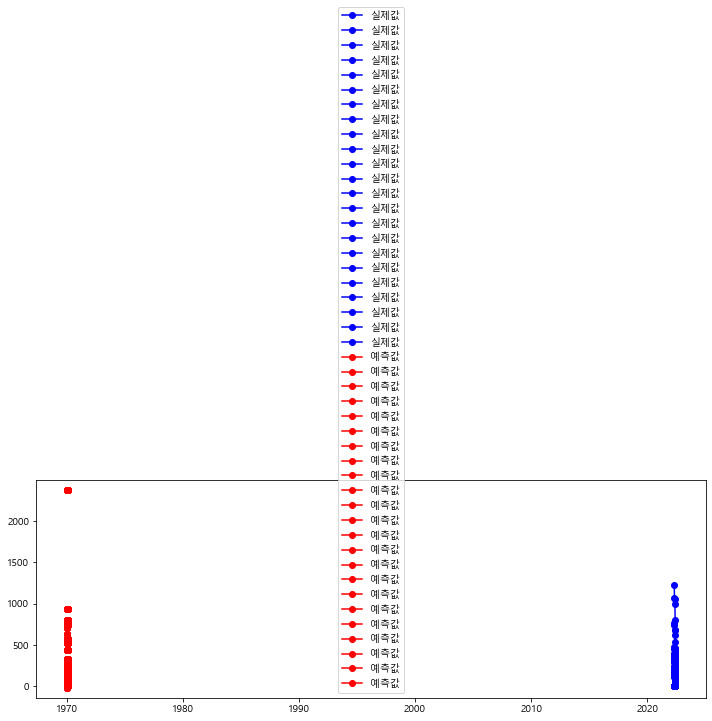

In [191]:
fig = plt.figure(figsize=(12,4))
chart = fig.add_subplot(1,1,1)
chart.plot(y_test[:200], marker='o', color='b', label='실제값')
chart.plot(Y_pred[:200], marker='o', color='r', label='예측값')
plt.legend(loc='best')

In [180]:
X_test['y_test'] = y_test
X_test['y_pred'] = Y_pred

X_test['H_YMD'] = pd.to_datetime(X_test['H_YMD'])
X_test.to_csv('C:\\Users\\user\\Desktop\\result.csv', encoding='utf-8-sig')

- RandomForesting

In [207]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=1000,
                                      min_samples_split=2,
                                      random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [211]:
rf_y_pred = rf_model.predict(X_test)

rf_y_pred

array([[ 196.626,  181.724,    5.427,  342.061,  111.292,  129.367,
         128.119,  211.474,    2.948,  371.8  , 1167.164,    9.742,
         495.334,   84.485,  318.45 ,  507.525,  210.127,  264.11 ,
          10.059,  806.118,  139.675,  495.005,  432.875],
       [ 204.431,  145.395,   21.219,  270.032,  126.902,  118.201,
         223.881,   46.987,   19.657,  426.506, 1134.008,   10.048,
         409.165,   15.512,  313.513,  453.549,  182.329,  237.823,
           7.905,  817.829,   97.531,  429.301,  512.702],
       [ 212.32 ,  156.246,   14.964,  292.5  ,  132.474,  125.288,
         235.318,   60.698,   10.462,  402.014, 1198.175,   24.425,
         447.709,   17.728,  333.288,  477.042,  192.908,  240.497,
          23.444,  778.082,  112.603,  436.356,  493.409],
       [ 175.497,  165.274,   46.332,  268.528,  125.275,  107.518,
         250.904,   26.525,   77.659,  376.214, 1189.104,   34.143,
         403.504,   10.249,  306.766,  450.699,  162.476,  230.054,
       

In [234]:
# import joblib

# joblib.dump(rf_model, 'rf_model_0706.pkl')

In [197]:
X_val.columns

Index(['O_YMD', 'GOODS_NO', 'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'PKG_GOODS_NM_단품',
       'PKG_GOODS_NM_세트', 'STD_GSGR_NO_LEV1_NM_국', 'STD_GSGR_NO_LEV1_NM_메인요리',
       'STD_GSGR_NO_LEV1_NM_반찬'],
      dtype='object')

In [212]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, rf_y_pred)
r2

-0.4313785571097234

In [213]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, rf_y_pred)**0.5
RMSE

129.54580780664176

In [215]:
y_test

,GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g),GOODS_NM_가정집 오징어불고기/셀프(380g),GOODS_NM_건고사리나물볶음(150g),GOODS_NM_건표고버섯볶음,GOODS_NM_고구마 품은 라자냐(450g),GOODS_NM_고사리나물볶음(150g),GOODS_NM_고소한도토리묵무침(265g),GOODS_NM_고소한도토리묵무침(360g),GOODS_NM_꼬막무침 (250g),GOODS_NM_꼬막무침 (260g),...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-01,163.0,191.0,0.0,308.0,142.0,114.0,0.0,299.0,0.0,355.0,...,389.0,323.0,387.0,209.0,310.0,0.0,743.0,124.0,470.0,328.0
2022-05-08,183.0,176.0,0.0,253.0,130.0,148.0,0.0,373.0,0.0,234.0,...,307.0,226.0,364.0,182.0,339.0,0.0,768.0,122.0,394.0,357.0
2022-05-15,215.0,183.0,0.0,233.0,233.0,181.0,0.0,449.0,0.0,250.0,...,294.0,308.0,401.0,377.0,236.0,0.0,688.0,133.0,412.0,294.0
2022-05-22,174.0,172.0,0.0,159.0,155.0,183.0,0.0,320.0,0.0,202.0,...,274.0,299.0,338.0,331.0,292.0,136.0,687.0,148.0,449.0,278.0
2022-05-29,145.0,109.0,0.0,216.0,141.0,193.0,0.0,280.0,0.0,176.0,...,265.0,267.0,617.0,183.0,240.0,316.0,537.0,137.0,379.0,336.0
2022-06-05,51.0,48.0,0.0,70.0,46.0,50.0,0.0,97.0,0.0,42.0,...,93.0,102.0,127.0,40.0,54.0,81.0,177.0,57.0,136.0,83.0


In [217]:
Y_test = test_data[['GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_NM_가정집 오징어불고기/셀프(380g)', 'GOODS_NM_건고사리나물볶음(150g)',
       'GOODS_NM_건표고버섯볶음', 'GOODS_NM_고구마 품은 라자냐(450g)',
       'GOODS_NM_고사리나물볶음(150g)', 'GOODS_NM_고소한도토리묵무침(265g)',
       'GOODS_NM_고소한도토리묵무침(360g)', 'GOODS_NM_꼬막무침 (250g)',
       'GOODS_NM_꼬막무침 (260g)', 'GOODS_NM_두메산나물비빔밥재료', 'GOODS_NM_메밀소바(2인분)',
       'GOODS_NM_셀프두부조림(600g)', 'GOODS_NM_소고기유니짜장소스(1인분, 200g)',
       'GOODS_NM_수제계란말이(350g)', 'GOODS_NM_숙주나물(300g)',
       'GOODS_NM_순살코다리강정(180g)', 'GOODS_NM_양장피', 'GOODS_NM_열무비빔밥재료믹스(2인분)',
       'GOODS_NM_옛날잡채(500g)', 'GOODS_NM_우삼겹숙주볶음(250g)', 'GOODS_NM_채소계란찜(340g)',
       'GOODS_NM_한돈 제육볶음(700g)']]

Y_test

,GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g),GOODS_NM_가정집 오징어불고기/셀프(380g),GOODS_NM_건고사리나물볶음(150g),GOODS_NM_건표고버섯볶음,GOODS_NM_고구마 품은 라자냐(450g),GOODS_NM_고사리나물볶음(150g),GOODS_NM_고소한도토리묵무침(265g),GOODS_NM_고소한도토리묵무침(360g),GOODS_NM_꼬막무침 (250g),GOODS_NM_꼬막무침 (260g),...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-01,163.0,191.0,0.0,308.0,142.0,114.0,0.0,299.0,0.0,355.0,...,389.0,323.0,387.0,209.0,310.0,0.0,743.0,124.0,470.0,328.0
2022-05-08,183.0,176.0,0.0,253.0,130.0,148.0,0.0,373.0,0.0,234.0,...,307.0,226.0,364.0,182.0,339.0,0.0,768.0,122.0,394.0,357.0
2022-05-15,215.0,183.0,0.0,233.0,233.0,181.0,0.0,449.0,0.0,250.0,...,294.0,308.0,401.0,377.0,236.0,0.0,688.0,133.0,412.0,294.0
2022-05-22,174.0,172.0,0.0,159.0,155.0,183.0,0.0,320.0,0.0,202.0,...,274.0,299.0,338.0,331.0,292.0,136.0,687.0,148.0,449.0,278.0
2022-05-29,145.0,109.0,0.0,216.0,141.0,193.0,0.0,280.0,0.0,176.0,...,265.0,267.0,617.0,183.0,240.0,316.0,537.0,137.0,379.0,336.0
2022-06-05,51.0,48.0,0.0,70.0,46.0,50.0,0.0,97.0,0.0,42.0,...,93.0,102.0,127.0,40.0,54.0,81.0,177.0,57.0,136.0,83.0


In [216]:
rf_y_pred = pd.DataFrame(rf_y_pred)

#rf_y_pred.REAL_ORD_QTY
rf_y_pred.columns = ['GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_NM_가정집 오징어불고기/셀프(380g)', 'GOODS_NM_건고사리나물볶음(150g)',
       'GOODS_NM_건표고버섯볶음', 'GOODS_NM_고구마 품은 라자냐(450g)',
       'GOODS_NM_고사리나물볶음(150g)', 'GOODS_NM_고소한도토리묵무침(265g)',
       'GOODS_NM_고소한도토리묵무침(360g)', 'GOODS_NM_꼬막무침 (250g)',
       'GOODS_NM_꼬막무침 (260g)', 'GOODS_NM_두메산나물비빔밥재료', 'GOODS_NM_메밀소바(2인분)',
       'GOODS_NM_셀프두부조림(600g)', 'GOODS_NM_소고기유니짜장소스(1인분, 200g)',
       'GOODS_NM_수제계란말이(350g)', 'GOODS_NM_숙주나물(300g)',
       'GOODS_NM_순살코다리강정(180g)', 'GOODS_NM_양장피', 'GOODS_NM_열무비빔밥재료믹스(2인분)',
       'GOODS_NM_옛날잡채(500g)', 'GOODS_NM_우삼겹숙주볶음(250g)', 'GOODS_NM_채소계란찜(340g)',
       'GOODS_NM_한돈 제육볶음(700g)']

rf_y_pred

,GOODS_NM__심방골주부X더반찬_ 시골 돼지짜글이(600g),GOODS_NM_가정집 오징어불고기/셀프(380g),GOODS_NM_건고사리나물볶음(150g),GOODS_NM_건표고버섯볶음,GOODS_NM_고구마 품은 라자냐(450g),GOODS_NM_고사리나물볶음(150g),GOODS_NM_고소한도토리묵무침(265g),GOODS_NM_고소한도토리묵무침(360g),GOODS_NM_꼬막무침 (250g),GOODS_NM_꼬막무침 (260g),...,"GOODS_NM_소고기유니짜장소스(1인분, 200g)",GOODS_NM_수제계란말이(350g),GOODS_NM_숙주나물(300g),GOODS_NM_순살코다리강정(180g),GOODS_NM_양장피,GOODS_NM_열무비빔밥재료믹스(2인분),GOODS_NM_옛날잡채(500g),GOODS_NM_우삼겹숙주볶음(250g),GOODS_NM_채소계란찜(340g),GOODS_NM_한돈 제육볶음(700g)
0,196.626,181.724,5.427,342.061,111.292,129.367,128.119,211.474,2.948,371.800,...,84.485,318.450,507.525,210.127,264.110,10.059,806.118,139.675,495.005,432.875
1,204.431,145.395,21.219,270.032,126.902,118.201,223.881,46.987,19.657,426.506,...,15.512,313.513,453.549,182.329,237.823,7.905,817.829,97.531,429.301,512.702
2,212.320,156.246,14.964,292.500,132.474,125.288,235.318,60.698,10.462,402.014,...,17.728,333.288,477.042,192.908,240.497,23.444,778.082,112.603,436.356,493.409
3,175.497,165.274,46.332,268.528,125.275,107.518,250.904,26.525,77.659,376.214,...,10.249,306.766,450.699,162.476,230.054,22.982,868.962,100.541,403.306,460.716
4,158.377,176.506,67.038,270.327,121.268,91.412,248.808,20.835,118.032,327.571,...,6.094,300.855,436.449,146.599,234.795,37.352,879.930,99.166,387.585,409.638
5,28.453,86.661,77.486,73.718,1.624,15.941,39.238,0.000,133.359,32.570,...,0.000,70.841,157.043,35.771,67.988,0.000,491.654,7.316,90.159,70.981


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


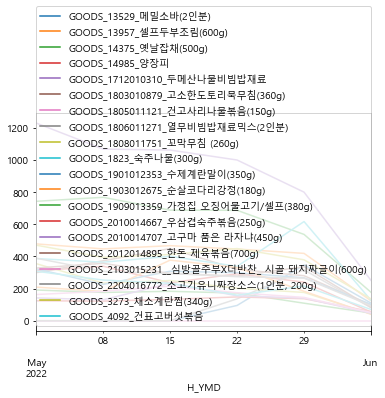

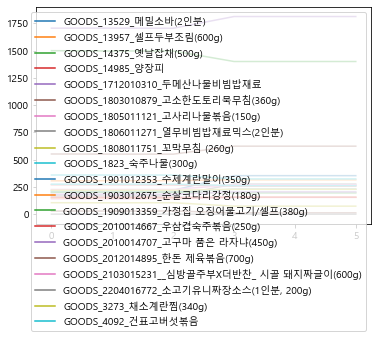

In [704]:

print(y_test.plot())
print(rf_y_pred.plot())

feature ranking
1. feature ORD_QTY ( 0.793)
2. feature FINAL_PRICE ( 0.003)
3. feature SALE_PRICE ( 0.001)
4. feature STD_GSGR_NO_LEV1_NM_메인요리 ( 0.066)
5. feature GOODS_1712010310_두메산나물비빔밥재료 ( 0.003)
6. feature STD_GSGR_NO_LEV1_NM_반찬 ( 0.083)
7. feature GOODS_1823_숙주나물(300g) ( 0.003)
8. feature GOODS_1909013359_가정집 오징어불고기/셀프(380g) ( 0.009)
9. feature PKG_GOODS_NM_세트 ( 0.007)
10. feature CANCEL_QTY ( 0.001)
11. feature DISCOUNT_AMT ( 0.003)
12. feature GOODS_14375_옛날잡채(500g) ( 0.001)
13. feature GOODS_2012014895_한돈 제육볶음(700g) ( 0.009)
14. feature GOODS_1901012353_수제계란말이(350g) ( 0.001)
15. feature RET_QTY ( 0.000)
16. feature GOODS_1803010879_고소한도토리묵무침(265g) ( 0.001)
17. feature GOODS_13957_셀프두부조림(600g) ( 0.000)
18. feature GOODS_1805011121_건고사리나물볶음(150g) ( 0.001)
19. feature GOODS_1806011271_열무비빔밥재료믹스(2인분) ( 0.001)
20. feature GOODS_14985_양장피 ( 0.000)
21. feature GOODS_3273_채소계란찜(340g) ( 0.005)
22. feature GOODS_1808011751_꼬막무침 (250g) ( 0.002)
23. feature GOODS_1903012675_순살코다리강정(180g) 

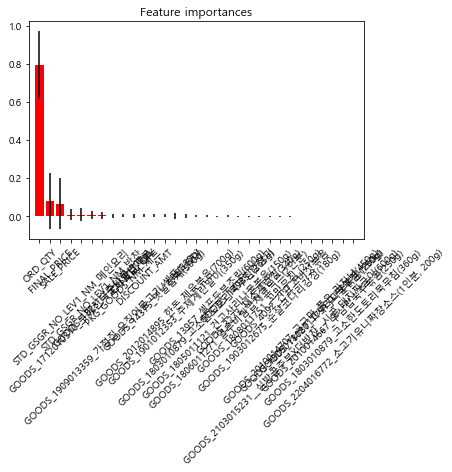

In [244]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('feature ranking')

for f in range(X_train.shape[1]):
    print('{}. feature {} ({: .3f})'.format(f + 1, X_train.columns[indices][f], importances[f]))

plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [564]:
X_train.head()

,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_세트,STD_GSGR_NO_LEV1_NM_메인요리,STD_GSGR_NO_LEV1_NM_반찬,...,COMMNET_CNT_4207,COMMNET_CNT_4919,COMMNET_CNT_5334,COMMNET_CNT_567,COMMNET_CNT_593,COMMNET_CNT_612,COMMNET_CNT_641,COMMNET_CNT_8522,COMMNET_CNT_931,COMMNET_CNT_971
H_YMD,,,,,,,,,,,,,,,,,,,,,
2020-01-12,3868,186,4,3682,23183800,752814.0,22430986,6.0,1960.0,1545.0,...,237.0,796.0,251.0,0.0,0.0,0.0,0.0,1018.0,0.0,94.0
2020-06-28,5506,295,13,5211,35366000,2168395.0,33197605,235.0,3029.0,1947.0,...,206.0,591.0,309.0,341.0,0.0,0.0,0.0,1421.0,0.0,0.0
2021-01-17,8165,331,46,7834,52567510,2981877.0,49585633,23.0,4256.0,3031.0,...,450.0,1133.0,318.0,0.0,328.0,0.0,373.0,1946.0,0.0,244.0
2020-02-23,3782,157,6,3625,22770100,735091.0,22035009,1.0,1820.0,1653.0,...,254.0,673.0,298.0,0.0,0.0,0.0,0.0,926.0,0.0,0.0
2020-07-05,4714,195,21,4519,29400700,1220395.0,28180305,201.0,2377.0,1872.0,...,236.0,573.0,319.0,360.0,0.0,0.0,0.0,1073.0,0.0,0.0


### 3.2 딥러닝 모델

## 4. 성능 비교

## 5. 비지니스 인사이트 도출